In [1]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import torch.nn.functional as F

/data1/miniconda3/envs/sg19/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir = '/data2/2021/zyj/Benchmark_ture'
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [3]:
# load detected results
detected_origin_path = f'{project_dir}/checkpoints/test_fre_div/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [4]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.2):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = prediction.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    pred_scores = prediction.get_field('pred_scores').tolist()
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    #理论上要取个softmax
    # print(pred_rel_label)

    # pred_rel_label=F.softmax(torch.log(pred_rel_label),dim=1)
    # print(pred_rel_label)
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    mask = pred_rel_score > thres
    pred_rel_score = pred_rel_score[mask]
    pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [73]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        if (draw_info == "7-surfboard"):
            draw.rectangle(((x1, y1), (x1+60, y1+10)), fill=color)
        else:
            draw.rectangle(((x1, y1), (x1+30, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info.split("-")[1])

def print_list(name, input_list, scores):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))
    
def draw_image(img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    li = [2,7,4,14,16]
    for i in range(num_obj):
        info = pred_labels[i]
        if(pred_scores[i]>0.0001) and i in li:
            draw_single_box(pic, boxes[i], draw_info=info)
            pass
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels, None)
        print('*' * 50)
        print_list('gt_rels', gt_rels, None)
        print('*' * 50)
    print_list('pred_labels', pred_labels, torch.tensor(pred_scores))
    print('*' * 50)
    print_list('pred_rels', pred_rels, pred_rel_score)
    print('*' * 50)
    
    return None

In [74]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        pass
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(f'Image {cand_idx}:')
        img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label = get_info_by_idx(cand_idx, detected_origin_result)
        draw_image(img_path=img_path, boxes=boxes, labels=labels, pred_labels=pred_labels, pred_scores=pred_scores, gt_rels=gt_rels, pred_rels=pred_rels, pred_rel_score=pred_rel_score, pred_rel_label=pred_rel_label, print_img=True)

Image 202:


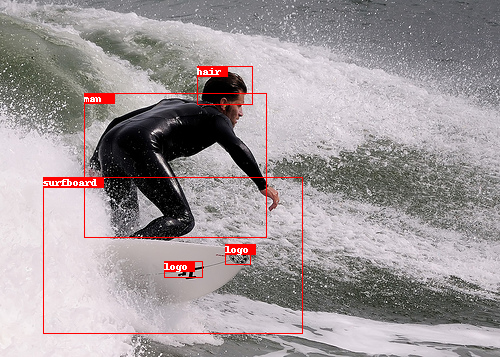

**************************************************
gt_boxes 0: 0-arm
gt_boxes 1: 1-board
gt_boxes 2: 2-man
gt_boxes 3: 3-head
gt_boxes 4: 4-logo
gt_boxes 5: 5-man
gt_boxes 6: 6-wave
gt_boxes 7: 7-surfboard
gt_boxes 8: 8-hair
gt_boxes 9: 9-wave
gt_boxes 10: 10-arm
gt_boxes 11: 11-logo
gt_boxes 12: 12-wave
gt_boxes 13: 13-wave
gt_boxes 14: 14-logo
gt_boxes 15: 15-wave
gt_boxes 16: 16-hair
**************************************************
gt_rels 0: ('5-man', 'on', '7-surfboard')
gt_rels 1: ('8-hair', 'on', '5-man')
gt_rels 2: ('7-surfboard', 'has', '11-logo')
gt_rels 3: ('5-man', 'on', '1-board')
gt_rels 4: ('14-logo', 'on', '1-board')
gt_rels 5: ('5-man', 'with', '2-man')
gt_rels 6: ('1-board', 'under', '2-man')
gt_rels 7: ('5-man', 'standing on', '7-surfboard')
gt_rels 8: ('16-hair', 'belonging to', '5-man')
gt_rels 9: ('5-man', 'wearing', '2-man')
gt_rels 10: ('16-hair', 'growing on', '3-head')
gt_rels 11: ('4-logo', 'painted on', '7-surfboard')
**************************************

In [75]:
show_all(start_idx=202, length=1)
#show_selected([119, 967, 713, 5224, 19681, 25371])